# Game Recommendation - Model Creation
Creates and saves TF-IDF matrix and DataFrame for use in recommendation script

In [8]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [9]:
# Load dataset
df = pd.read_csv('datasets/steam-games-cleaned.csv')
df['genres'] = df['genres'].fillna('')
df['tags'] = df['tags'].fillna('')
df = df.reset_index(drop=True)

print(f'Dataset size: {len(df)}')

Dataset size: 42410


In [10]:
# Weighted tags function - first tags are more important
def create_weighted_tags(tags_str, decay_factor=0.8):
    if pd.isna(tags_str) or tags_str == '':
        return ''
    tags = [t.strip() for t in tags_str.split(',')]
    weighted_tags = []
    for i, tag in enumerate(tags):
        weight = decay_factor ** i
        repetitions = max(1, int(weight * 5))
        weighted_tags.extend([tag] * repetitions)
    return ' '.join(weighted_tags)

# Create features
df['weighted_tags'] = df['tags'].apply(create_weighted_tags)
df['features'] = df['genres'].str.replace('_', ' ') + ' ' + df['weighted_tags']

In [11]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['features'])

print(f'TF-IDF matrix shape: {tfidf_matrix.shape}')

TF-IDF matrix shape: (42410, 100)


## Visualization with K-Means Clustering

In [12]:
# K-Means for visualization (K=8)
kmeans = KMeans(n_clusters=8, random_state=42, n_init=20)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

print('Cluster distribution:')
print(df['cluster'].value_counts().sort_index())

Cluster distribution:
cluster
0    11734
1     6338
2     2075
3     3871
4     7673
5     4204
6     3018
7     3497
Name: count, dtype: int64


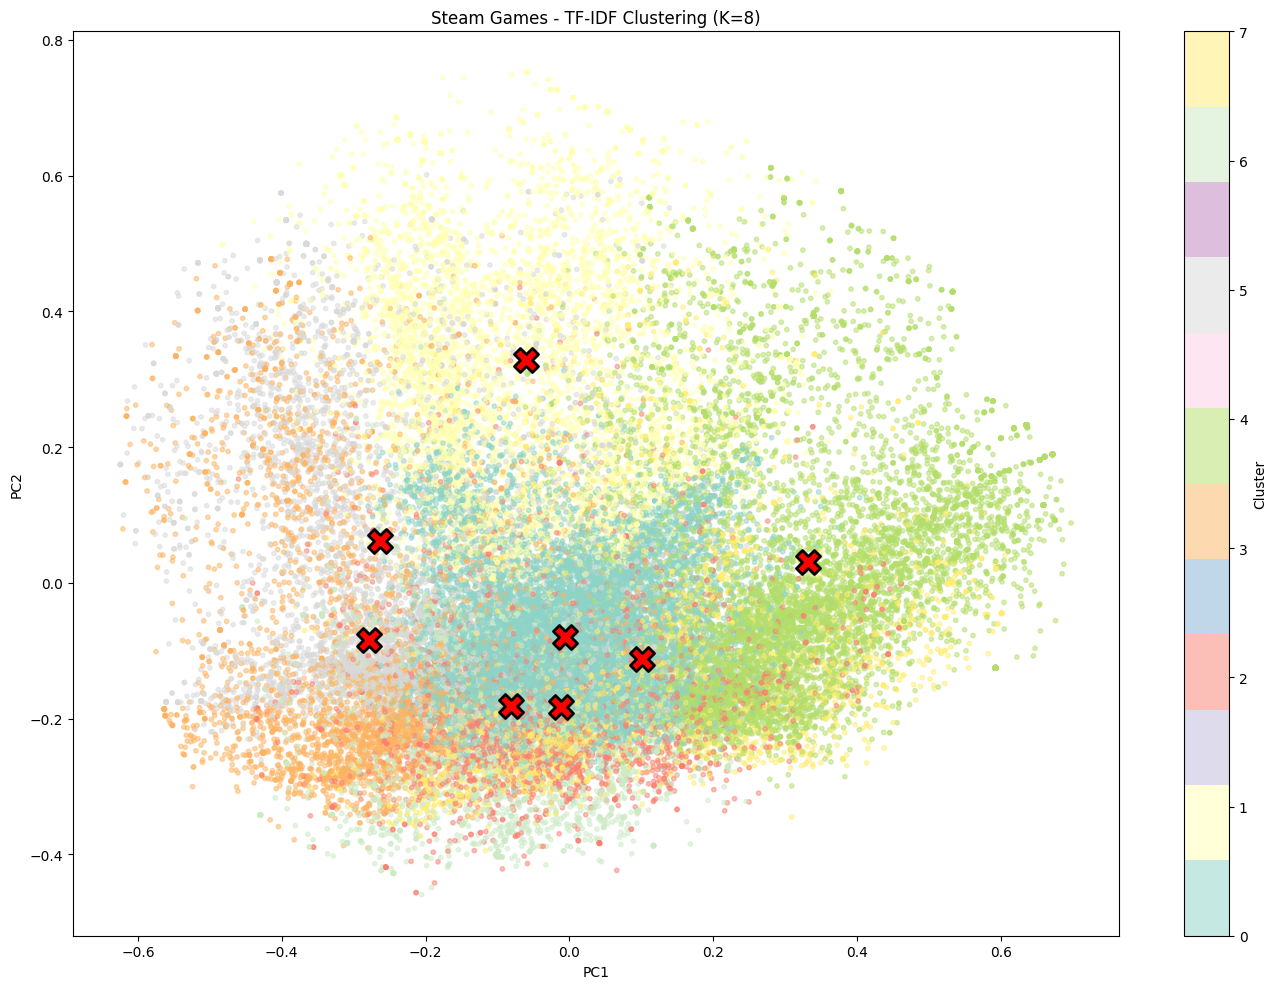

In [13]:
# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(14, 10))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df['cluster'], cmap='Set3', alpha=0.5, s=10)

# Plot cluster centers
centers_2d = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', marker='X', s=300, edgecolors='black', linewidths=2)

plt.colorbar(scatter, label='Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Steam Games - TF-IDF Clustering (K=8)')
plt.tight_layout()
plt.show()

## Save Model

In [14]:
# Save model and data (Consolidated)
# 1. Select only necessary columns
df_clean = df[['app_id', 'title', 'genres', 'tags', 'review_score']]

# 2. Create the complete package
model_data = {
    'dataframe': df_clean,
    'matrix': tfidf_matrix,
    'vectorizer': tfidf
}

# 3. Save to a single file
with open('models/steam_recommender.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print('Complete model saved to models/steam_recommender.pkl')

Complete model saved to models/steam_recommender.pkl
